In [33]:
import pandas as pd
import folium as fo
import numpy as np
import datetime
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import json
pd.set_option('mode.chained_assignment', None)

# Violation frequency  
## Violation frequency by violation category  
Regrouping violations in common categories will need less plots while maintening readability and finer analysis.  
To do so, we created 5 categories (food safety, hygiene, equipment, recidivism and others).  
For the analysis, we first map violation's id to their new category and then proceed as usual.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
violation_category_mapping = pd.read_csv('resources/violation-id-meaning.csv').rename(columns={'Violation ID': 'id', 'Category': 'category'})
violation_category_mapping.index = violation_category_mapping.id
violation_category_mapping = violation_category_mapping.category

violation_categories = violation_category_mapping.unique()
violation_category_mapping.head()

id
1    Food safety
2    Food safety
3    Food safety
4    Food safety
5        Hygiene
Name: category, dtype: object

We also restrict the analysis to certain types of facility: ie restaurants and grocery stores.  

In [4]:
inspections = pd.read_parquet('resources/food-inspections-cleaned.parquet').rename(columns={'Inspection Date': 'date'})

In [5]:
categorized_violations = pd.read_parquet('resources/violations_oriented.parquet').rename(columns={'Violation ID': 'id', 'Inspection Date': 'date'})
categorized_violations.index = categorized_violations.date
categorized_violations['category'] = categorized_violations.id.map(lambda x: violation_category_mapping.get(x))

## Franchise oriented analysis

In [6]:
columns_rename = {'AKA Name': 'name', 'License #': 'license', 'Ward': 'ward', 'Violation IDs': 'violations', 'Inspection Date': 'date', 'Results': 'result', 'Risk': 'risk'}
columns_filter = columns_rename.values()
violations = pd.read_parquet('resources/cleaned_franchises.parquet').rename(columns=columns_rename)[columns_filter]
violations.columns

Index(['name', 'license', 'ward', 'violations', 'date', 'result', 'risk'], dtype='object')

In [7]:
violation_category_mapping = pd.read_csv('resources/violation-id-meaning.csv').rename(columns={'Violation ID': 'id', 'Category': 'category'})
violation_category_mapping.index = violation_category_mapping.id
violation_category_mapping = violation_category_mapping.category

violation_categories = violation_category_mapping.unique()
'Violations categories are: ' + ' - '.join(violation_category_mapping.unique())

'Violations categories are: Food safety - Hygiene - Equipment - Recidivism - Other'

In [8]:
studied_franchises = ['SUBWAY', 'DUNKINDONUTS', 'MCDONALDS',\
                     'STARBUCKS', 'BURGERKING', 'POPEYES',\
                     'POTBELLYSANDWICH', 'CHIPOTLE', 'KFC',\
                     'HAROLDSCHICKEN', 'DOMINOS', 'WENDYS',\
                     'PIZZAHUT', 'AUBONPAIN', 'PAPAJOHNSPIZZA',\
                     'JAMBAJUICE', 'WINGSTOP', 'FRESHII',\
                     'JIMMYJOHNS', 'JJFISH',]
print('We are studying {} franchises.'.format(len(studied_franchises)))


We are studying 20 franchises.


## I] Franchises vs the rest of Chicago  
### 1] Average inspections per license 

In [9]:
licenses_per_name = violations[['name', 'license']].groupby(by='name').nunique()[['license']].rename(columns={'license': 'licenses'}).sort_values(by='licenses', ascending=False)
licenses_per_name.head()

,licenses
name,
SUBWAY,465
7ELEVEN,324
DUNKINDONUTS,305
STARBUCKS,255
MCDONALDS,202


In [10]:
inspections_per_name = violations.copy()[['name']]
inspections_per_name['inspections'] = 1
inspections_per_name = inspections_per_name.groupby(by='name').count().sort_values(by='inspections', ascending=False)
inspections_per_name.head()

,inspections
name,
SUBWAY,4107
DUNKINDONUTS,2357
MCDONALDS,2080
STARBUCKS,1427
7ELEVEN,1396


In [11]:
avg_inspections_per_license = licenses_per_name.join(inspections_per_name)
avg_inspections_per_license['inspections/license'] = avg_inspections_per_license.inspections / avg_inspections_per_license.licenses
avg_inspections_per_license = avg_inspections_per_license.drop(['inspections', 'licenses'], axis=1)
avg_inspections_per_license['is_franchise'] = avg_inspections_per_license.index.isin(studied_franchises)
avg_inspections_per_license.is_franchise = avg_inspections_per_license.is_franchise.map(lambda x: 'Franchise' if x else 'Individual')

In [12]:
avg_inspections_per_license.groupby(by='is_franchise').mean()

,inspections/license
is_franchise,
Franchise,7.475303
Individual,5.129013


Franchises are more inspected :)

### 2] Violations categories periodicity

In [13]:
exploded_violations = violations.explode('violations')
exploded_violations = exploded_violations[exploded_violations.violations != 'None']
exploded_violations.violations = exploded_violations.violations.astype('int32').map(lambda x: violation_category_mapping.get(x))
exploded_violations['is_franchise'] = exploded_violations.name.isin(studied_franchises).map(lambda x: 'Franchise' if x else 'Individual')
exploded_violations.head(5)

,name,license,ward,violations,date,result,risk,is_franchise
Inspection ID,,,,,,,,
44247,EATAPITA,1222441,44,Other,2010-01-05,Pass,High,Individual
44247,EATAPITA,1222441,44,Equipment,2010-01-05,Pass,High,Individual
44247,EATAPITA,1222441,44,Hygiene,2010-01-05,Pass,High,Individual
44247,EATAPITA,1222441,44,Hygiene,2010-01-05,Pass,High,Individual
44247,EATAPITA,1222441,44,Equipment,2010-01-05,Pass,High,Individual


In [14]:
violation_categories_periodicity = exploded_violations.copy()
violation_categories_periodicity = violation_categories_periodicity[['is_franchise', 'violations', 'date']]
violation_categories_periodicity['v_count'] = 1
violation_categories_periodicity = violation_categories_periodicity.groupby(by=['is_franchise', 'violations', 'date']).sum().reset_index()
violation_categories_periodicity.head()

,is_franchise,violations,date,v_count
0,Franchise,Equipment,2010-01-05,3
1,Franchise,Equipment,2010-01-06,17
2,Franchise,Equipment,2010-01-07,11
3,Franchise,Equipment,2010-01-08,2
4,Franchise,Equipment,2010-01-11,1


We want to normalize this count by the number of inspections.

In [15]:
inspections_per_day_and_franchise = violations.copy()[['name', 'date']]
inspections_per_day_and_franchise['is_franchise'] = inspections_per_day_and_franchise.name.isin(studied_franchises).map(lambda x: 'Franchise' if x else 'Individual')
inspections_per_day_and_franchise = inspections_per_day_and_franchise.drop('name', axis=1)
inspections_per_day_and_franchise['i_count'] = 1
inspections_per_day_and_franchise = inspections_per_day_and_franchise.groupby(by=['is_franchise', 'date']).sum()
inspections_per_day_and_franchise.head()

i_count
is_franchise date               
Franchise    2010-01-04        1
             2010-01-05        3
             2010-01-06       15
             2010-01-07        7
             2010-01-08        4

In [16]:
category_rate = inspections_per_day_and_franchise.merge(violation_categories_periodicity, left_on=['is_franchise', 'date'], right_on=['is_franchise', 'date']).rename(columns={'violations': 'category'})
category_rate['rate'] = category_rate.v_count / category_rate.i_count
category_rate = category_rate.drop(['i_count', 'v_count'], axis=1)
category_rate.head()

,is_franchise,date,category,rate
0,Franchise,2010-01-05,Equipment,1.000000
1,Franchise,2010-01-05,Hygiene,3.333333
2,Franchise,2010-01-05,Other,0.666667
3,Franchise,2010-01-06,Equipment,1.133333
4,Franchise,2010-01-06,Food safety,0.133333


C:\Users\Nicolas\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


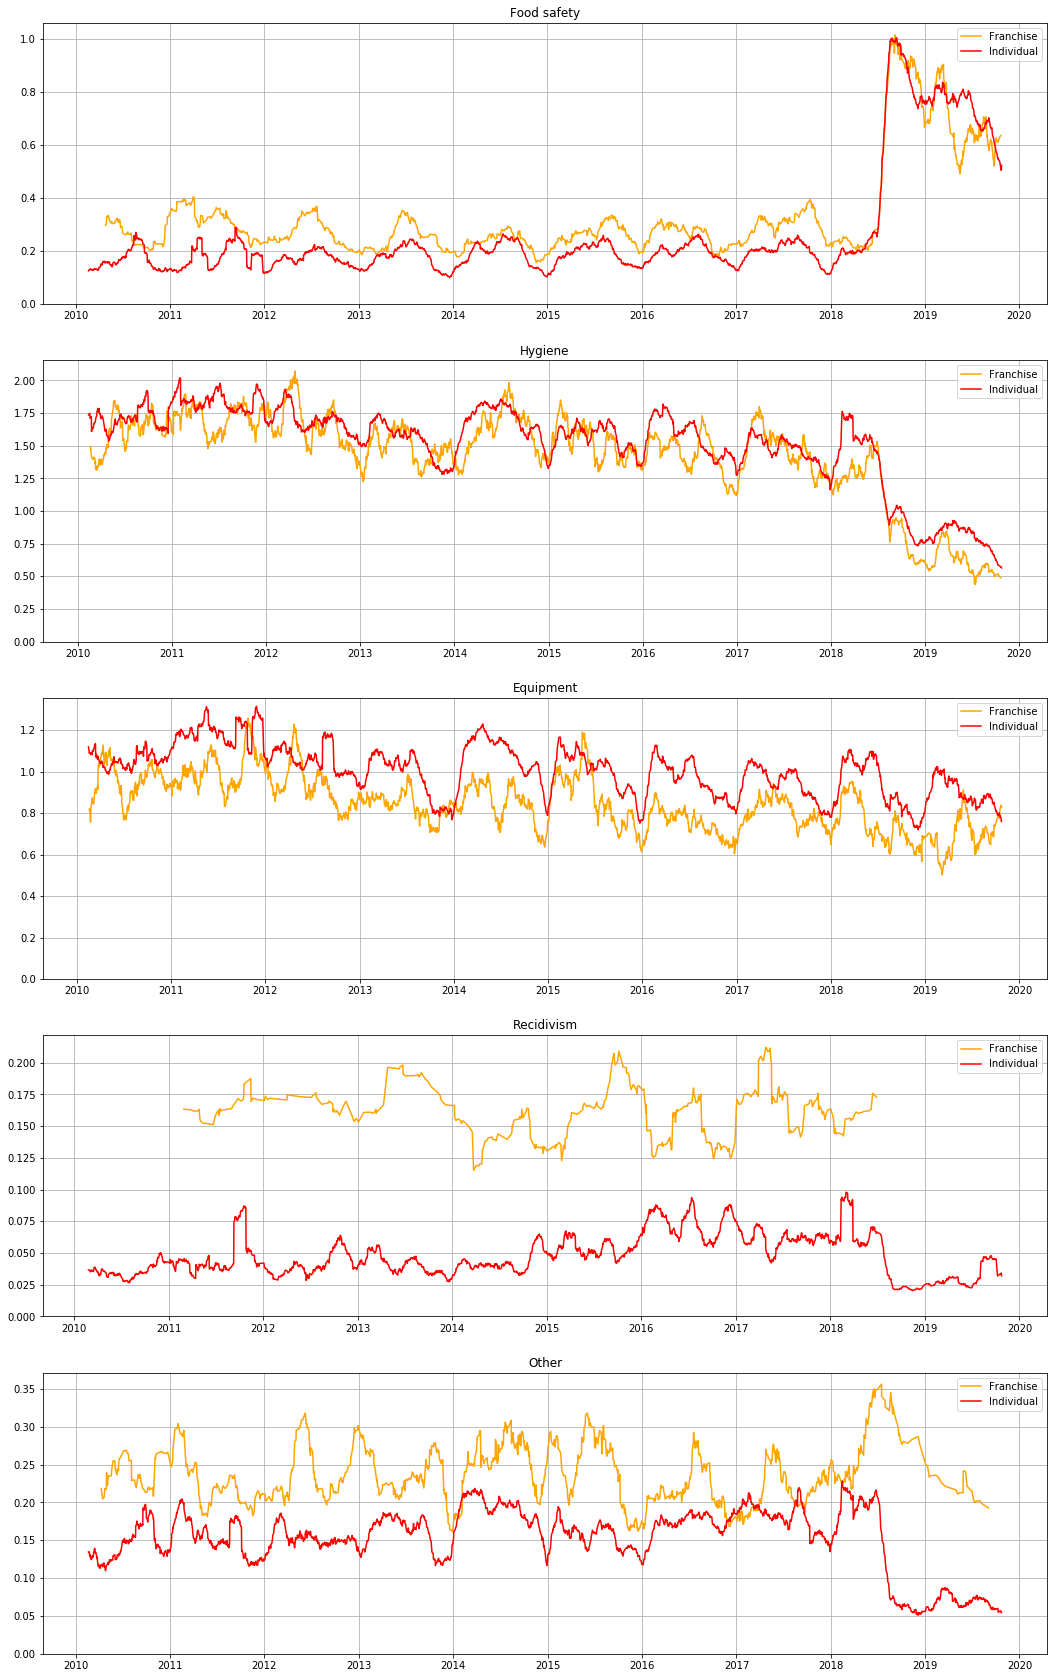

In [17]:
franchises = category_rate.is_franchise.unique()
colors = ['orange', 'red']
fig, axs = plt.subplots(len(violation_categories), 1, figsize=(18,30))

for j, franchise in enumerate(franchises):
    franchise_rate = category_rate[category_rate.is_franchise == franchise]
    for i, v_cat in enumerate(violation_categories):
        filtered = franchise_rate[franchise_rate.category == v_cat]
        rolling_mean = filtered.rate.rolling(window=30).mean()
        axs[i].set_title('{}'.format(v_cat))
        axs[i].plot(filtered['date'].values, rolling_mean, colors[j])
        
for i, v_cat in enumerate(violation_categories):
    axs[i].legend(franchises)
    axs[i].grid()
    axs[i].set_ylim(bottom=0)

Overall, franchises have around +50% food safety violations, -25% equipment violations and more than about 2 to 5 times the amount of recidivism violations compared to non franchise stores.  

While big franchises want to maximize profit by making the most possible sales, it has a high impact on the overall sanitization of the restaurant.  
The high recidivism is surely the result of big corporation not caring enough about inspections and willing to make more profit while not caring about overall safety.

## II] Franchise groups vs each others  
This time, we will group every franchise in a group (ie: burgers, wraps, ...).  
This may reveal some interesting facts about different franchise types.

In [18]:
def franchise_map(franchise):
    if franchise in ['KFC', 'POPEYES', 'HAROLDSCHICKEN', 'WINGSTOP', 'JJFISH']: return 'Chicken/Fish'
    elif franchise in ['SUBWAY', 'POTBELLYSANDWICH', 'JIMMYJOHNS', 'AUBONPAIN']: return 'Sandwich'
    elif franchise in ['PIZZAHUT', 'DOMINOS', 'PAPAJOHNSPIZZA']: return 'Pizza'
    elif franchise in ['MCDONALDS', 'BURGERKING', 'WENDYS']: return 'Burger'
    elif franchise in ['JAMBAJUICE', 'STARBUCKS']: return 'Drink'
    return 'Other'

### 1] Average inspections per license per group

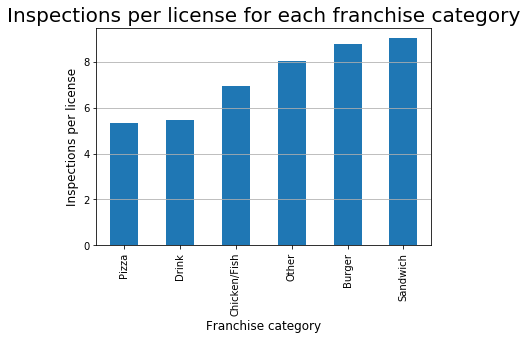

In [19]:
grouped_franchises_licenses = licenses_per_name[licenses_per_name.index.isin(studied_franchises)]
grouped_franchises_licenses.index = grouped_franchises_licenses.index.map(franchise_map)
grouped_franchises_licenses = grouped_franchises_licenses.groupby(by='name').sum()

grouped_franchises_inspections = inspections_per_name[inspections_per_name.index.isin(studied_franchises)]
grouped_franchises_inspections.index = grouped_franchises_inspections.index.map(franchise_map)
grouped_franchises_inspections = grouped_franchises_inspections.groupby(by='name').sum()

inpections_per_license_per_inspection_group = grouped_franchises_licenses.join(grouped_franchises_inspections)
inpections_per_license_per_inspection_group['rate'] = inpections_per_license_per_inspection_group.inspections / inpections_per_license_per_inspection_group.licenses

bar = inpections_per_license_per_inspection_group.rate.sort_values().plot.bar()
bar.set_title('Inspections per license for each franchise category', fontsize=20)
bar.set_xlabel('Franchise category', fontsize=12)
bar.set_ylabel('Inspections per license', fontsize=12)
bar.grid(axis='y')

Clearly, two groups are more controlled than others: burger and sandwich fast foods.  
It contrast with pizza and coffee/milkshake place that are about 30% less inspected.

### 2] Violation average per group

In [20]:
franchises_inspections = violations[violations.name.isin(studied_franchises)]

groups_inspections = franchises_inspections.copy()
groups_inspections.name = groups_inspections.name.map(franchise_map)
groups_inspections.head()

,name,license,ward,violations,date,result,risk
Inspection ID,,,,,,,
2320374,Other,1909364,13,"[38, 47, 55, 57, 59]",2019-10-24,Fail,Medium
2320265,Pizza,2495920,14,"[3, 49]",2019-10-22,Pass w/ Conditions,Medium
2320281,Other,2698419,42,"[3, 5, 40, 40, 51, 53, 55]",2019-10-22,Pass w/ Conditions,Medium
2316204,Chicken/Fish,24698,21,[57],2019-10-21,Pass,Medium
2316090,Burger,1145755,18,"[49, 55, 55, 56]",2019-10-18,Pass,High


In [21]:
groups_violations = groups_inspections.explode('violations').rename(columns={'violations': 'id'})
groups_violations.head()

,name,license,ward,id,date,result,risk
Inspection ID,,,,,,,
44254,Sandwich,2026336,40,None,2010-04-01,Pass,High
48227,Burger,1933100,37,32,2010-03-10,Pass,Medium
48227,Burger,1933100,37,33,2010-03-10,Pass,Medium
48227,Burger,1933100,37,34,2010-03-10,Pass,Medium
48227,Burger,1933100,37,35,2010-03-10,Pass,Medium


In [22]:
violations_per_group = groups_violations[['name', 'id', 'date']]
violations_per_group = violations_per_group[violations_per_group.id != 'None']
violations_per_group['category'] = violations_per_group.id.astype('int32').map(violation_category_mapping.get)
violations_per_group['v_count'] = 1
violations_per_group = violations_per_group.drop('id', axis=1)

violations_per_group_overall = violations_per_group.drop('date', axis=1).groupby(by=['name','category']).sum()
violations_per_group_overall.head()

v_count
name   category            
Burger Equipment       3027
       Food safety      582
       Hygiene         5253
       Other            231
       Recidivism        98

In [23]:
avg_violations_per_group_per_inspection = violations_per_group_overall.join(grouped_franchises_inspections)
avg_violations_per_group_per_inspection['rate'] = avg_violations_per_group_per_inspection.v_count / avg_violations_per_group_per_inspection.inspections
avg_violations_per_group_per_inspection = avg_violations_per_group_per_inspection.drop(['v_count', 'inspections'], axis=1)
avg_violations_per_group_per_inspection.head()

rate
name   category             
Burger Equipment    0.923711
       Food safety  0.177601
       Hygiene      1.602991
       Other        0.070491
       Recidivism   0.029905

In [24]:
avg_violations_per_group_per_inspection.reset_index().pivot(index='name', columns='category', values='rate')

category,Equipment,Food safety,Hygiene,Other,Recidivism
name,,,,,
Burger,0.923711,0.177601,1.602991,0.070491,0.029905
Chicken/Fish,0.917127,0.190820,1.733107,0.149171,0.045049
Drink,0.578502,0.135505,1.193485,0.079479,0.016938
Other,0.856959,0.228737,1.341173,0.172036,0.034472
Pizza,0.724965,0.155148,1.356841,0.224260,0.040903
Sandwich,0.727966,0.224247,1.253626,0.128300,0.031796


### 3] Violation periodicity per group

In [25]:
inspections_per_group_per_day = groups_inspections[['name', 'date']]
inspections_per_group_per_day['i_count'] = 1
inspections_per_group_per_day = inspections_per_group_per_day.groupby(by=['name', 'date']).sum()
inspections_per_group_per_day.head()

i_count
name   date               
Burger 2010-01-06        5
       2010-01-07        3
       2010-01-08        3
       2010-01-11        3
       2010-01-12        2

In [26]:
violations_per_group_per_day = violations_per_group.copy()
violations_per_group_per_day = violations_per_group_per_day.groupby(by=['name', 'category', 'date']).sum().reset_index('category')
violations_per_group_per_day.head()

category  v_count
name   date                          
Burger 2010-01-07  Equipment        5
       2010-01-08  Equipment        1
       2010-01-11  Equipment        1
       2010-01-13  Equipment        2
       2010-01-15  Equipment        1

In [27]:
category_rate_per_group = inspections_per_group_per_day.join(violations_per_group_per_day)
category_rate_per_group['rate'] = category_rate_per_group.v_count / category_rate_per_group.i_count
category_rate_per_group = category_rate_per_group.drop(['i_count', 'v_count'], axis=1).reset_index()
category_rate_per_group.head()

,name,date,category,rate
0,Burger,2010-01-06,Hygiene,0.400000
1,Burger,2010-01-07,Equipment,1.666667
2,Burger,2010-01-07,Hygiene,2.333333
3,Burger,2010-01-08,Equipment,0.333333
4,Burger,2010-01-08,Hygiene,1.666667


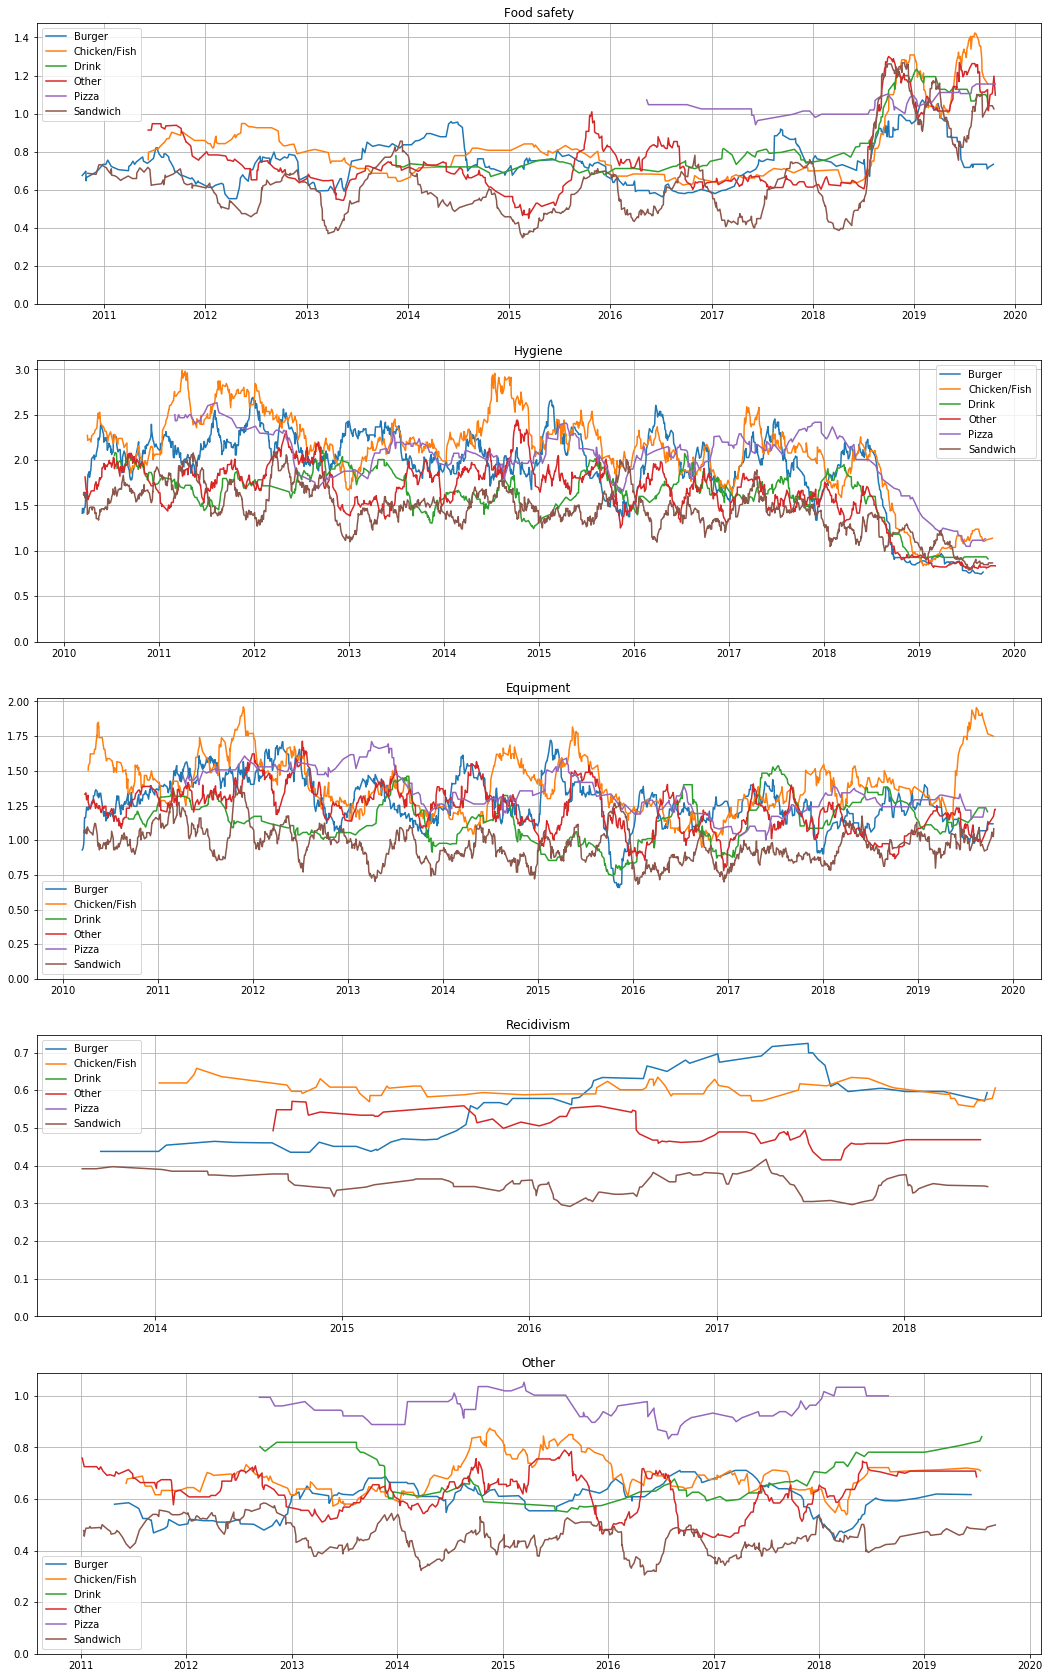

In [63]:
groups = category_rate_per_group.name.unique()
colors = ['orange', 'red']
fig, axs = plt.subplots(len(violation_categories), 1, figsize=(18,30))

for j, group in enumerate(groups):
    group_rate = category_rate_per_group[category_rate_per_group.name == group]
    for i, v_cat in enumerate(violation_categories):
        filtered = group_rate[group_rate.category == v_cat]
        
        rolling_mean = filtered.rate.rolling(window=30).mean()
        axs[i].set_title('{}'.format(v_cat))
        axs[i].plot(filtered['date'].values, rolling_mean)
        
for i, v_cat in enumerate(violation_categories):
    axs[i].legend(groups)
    axs[i].grid()
    axs[i].set_ylim(bottom=0)

## II] Franchise group members vs each others (per month)

In [84]:
franchises_inspections = violations[violations.name.isin(studied_franchises)]
franchises_inspections['group'] = franchises_inspections.name.map(franchise_map)
franchises_inspections.date = franchises_inspections.date.map(lambda x: x.year)

inspections_per_franchises = franchises_inspections[['name', 'group', 'date']]
inspections_per_franchises['i_count'] = 1
inspections_per_franchises = inspections_per_franchises.groupby(by=['name', 'group', 'date']).sum()
inspections_per_franchises.head()

i_count
name      group    date         
AUBONPAIN Sandwich 2010       16
                   2011       27
                   2012       23
                   2013       29
                   2014       30

In [85]:
violations_per_franchise = franchises_inspections.explode('violations')
violations_per_franchise = violations_per_franchise[violations_per_franchise.violations != 'None']
violations_per_franchise['category'] = violations_per_franchise.violations.astype('int32').map(violation_category_mapping.get)
violations_per_franchise = violations_per_franchise[['name', 'group', 'category', 'date']]
violations_per_franchise['v_count'] = 1
violations_per_franchise = violations_per_franchise.groupby(by=['name', 'group', 'category', 'date']).sum().reset_index('category')
violations_per_franchise.head()

category  v_count
name      group    date                    
AUBONPAIN Sandwich 2010  Equipment        9
                   2011  Equipment       18
                   2012  Equipment       20
                   2013  Equipment       25
                   2014  Equipment       15

In [93]:
merged = inspections_per_franchises.join(violations_per_franchise)
merged['rate'] = merged.v_count / merged.i_count
merged = merged.drop(['v_count', 'i_count'], axis = 1).reset_index()
merged[merged.date == 2016].head(10)

,name,group,date,category,rate
24,AUBONPAIN,Sandwich,2016,Equipment,0.718750
25,AUBONPAIN,Sandwich,2016,Food safety,0.406250
26,AUBONPAIN,Sandwich,2016,Hygiene,2.156250
27,AUBONPAIN,Sandwich,2016,Other,0.187500
28,AUBONPAIN,Sandwich,2016,Recidivism,0.031250
71,BURGERKING,Burger,2016,Equipment,0.853659
72,BURGERKING,Burger,2016,Food safety,0.060976
73,BURGERKING,Burger,2016,Hygiene,1.878049
74,BURGERKING,Burger,2016,Other,0.243902
75,BURGERKING,Burger,2016,Recidivism,0.024390


Plotting group: Sandwich
Plotting group: Burger
Plotting group: Other
Plotting group: Pizza
Plotting group: Chicken/Fish
Plotting group: Drink


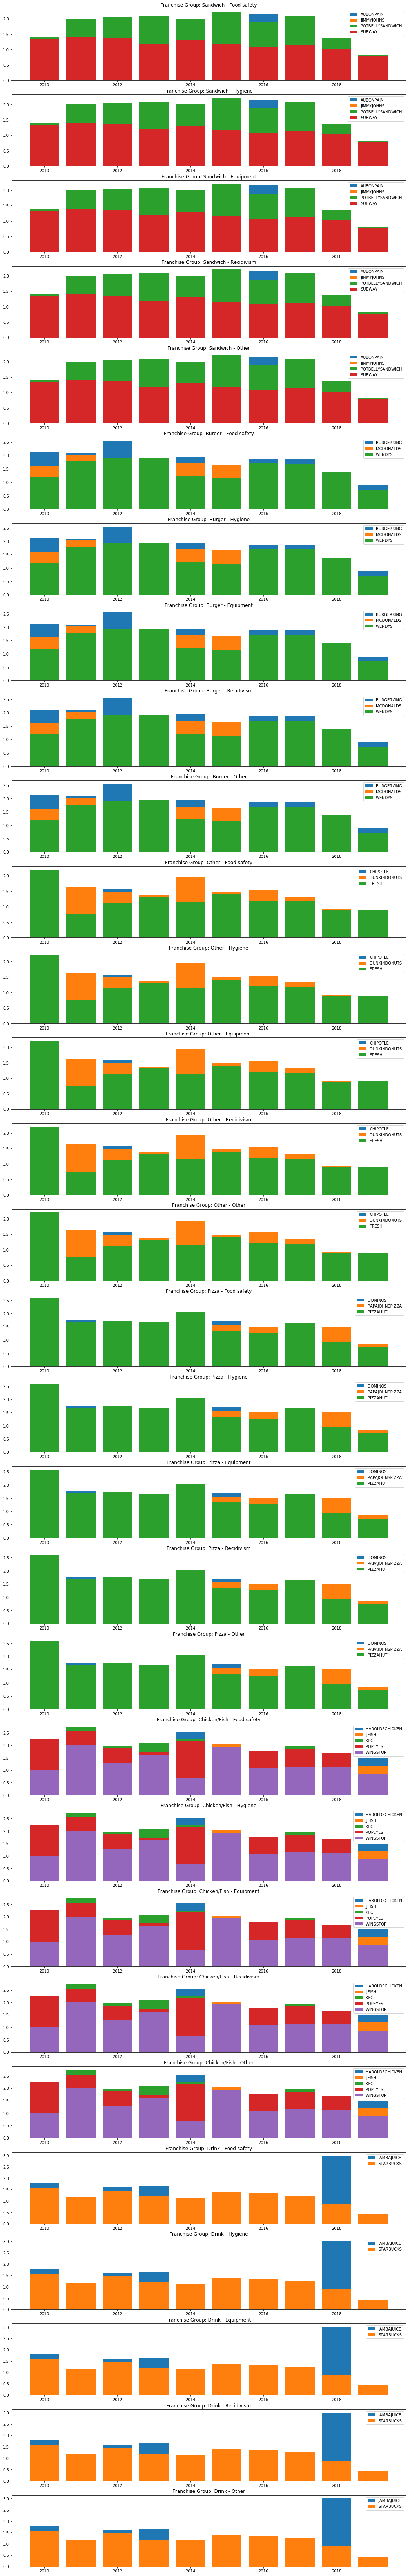

In [89]:
groups = merged.group.unique()
names = []

for group in groups:
    names.append(merged[merged.group == group].name.unique())
    
fig, axs = plt.subplots(len(violation_categories) * len(groups), 1, figsize=(18,120))

for i, group in enumerate(groups):
    print('Plotting group: {}'.format(group))
    group_rate = merged[merged.group == group]
    
    for j, name in enumerate(names[i]):
        name_rate = group_rate[group_rate.name == name]
        
        for k, cat in enumerate(violation_categories):
            filtered = name_rate[name_rate.category == cat]
            #rolling_mean = name_rate.rate.rolling(window=3).mean()
            rolling_mean = name_rate.rate
            axs[k + i * len(violation_categories)].set_title('Franchise Group: {} - {}'.format(group, cat))
            axs[k + i * len(violation_categories)].bar(name_rate['date'].values, rolling_mean)
        
for i, group in enumerate(groups):
    for k, cat in enumerate(violation_categories):
        axs[k + i * len(violation_categories)].legend(names[i])